# pre-processing

In [1]:
#enable autocomplete
%config IPCompleter.greedy=True 

#load packages
import sys #access to system parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#load data
file_path = r"titanic_train.csv"
data = pd.read_csv(file_path)
#complete missing age with median
data['Age'].fillna(data['Age'].median(), inplace = True)

#complete missing fare with median
data['Fare'].fillna(data['Fare'].median(), inplace = True)

#complete embarked with mode
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

#complete Cabin with mode
data['Cabin'].fillna(data['Cabin'].mode()[0], inplace = True)

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

data['IsAlone'] = 1 #initialize to yes/1 is alone
data['IsAlone'].loc[data['FamilySize'] > 1] = 0

def my_regex(x):
    try:
        num = re.search(r'[0-9]+',x)
        return num.group(0)
    except:
        return 0
    return 

data['Cabin Num'] = data.Cabin.apply(lambda x : my_regex(x))    
#data.head()  

x = data[['Cabin Num','IsAlone','FamilySize','Parch','SibSp','Age','Fare']]

y = data.Survived

C:\Users\zigi\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Steps of clustering research

# SVM - OneClassSVM
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

## SVM - scaling

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
pca_scaler = PCA(n_components=4)

standard_scaler.fit(x)
minmax_scaler.fit(x)
pca_scaler.fit(x)

standard_x = standard_scaler.transform(x)
minmax_x = minmax_scaler.transform(x)
pca_x = pca_scaler.transform(x)

C:\Users\zigi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zigi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\zigi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


## SVM - choose the number of cluster

In [54]:
from sklearn.svm import OneClassSVM


svm_clf = OneClassSVM(gamma='auto',nu = 0.4).fit(pca_x)#(gamma='auto',nu = 0.01)
y_pred =svm_clf.predict(pca_x)


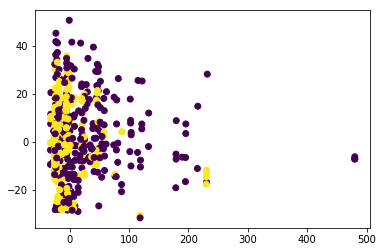

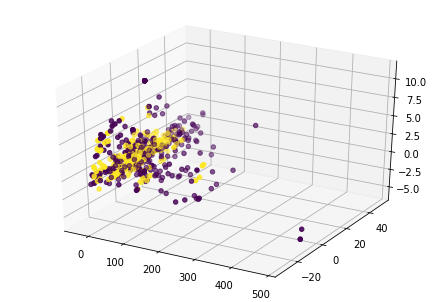

In [55]:
#check result using PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=2)
pca.fit(pca_x)  
x_pca = pca.transform(pca_x)

pca_cluster_center = PCA(n_components=2)

#2D plot
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_pred,alpha=1)
plt.show()

pca = PCA(n_components=3)
pca.fit(pca_x)  
x_pca = pca.transform(pca_x)

pca_cluster_center = PCA(n_components=3)

#3D plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_pca[:,0],x_pca[:,1],x_pca[:,2],c=y_pred)
plt.show()

# SVM - silhouette_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

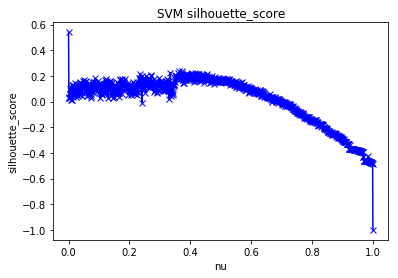

In [52]:
from sklearn.metrics import silhouette_score

silhouette_score_list = []
nu_range = np.linspace(0.0001,1,1000)

for nu_val in nu_range:
    
    svm_clf = OneClassSVM(gamma='auto',nu = nu_val).fit(pca_x)
    y_pred =svm_clf.predict(pca_x)
    
    if len(np.unique(y_pred)) > 1:
        svm_silhouette_score = silhouette_score(pca_x,y_pred)
        silhouette_score_list.append(svm_silhouette_score)
    else:
        silhouette_score_list.append(-1)
    


plt.plot(nu_range, silhouette_score_list, 'bx-')
plt.xlabel('nu')
plt.ylabel('silhouette_score')
plt.title('SVM silhouette_score')
plt.show()

In [53]:
silhouette_score_np = np.array(silhouette_score_list)
silhouette_score_np.argmax()
silhouette_score_list[silhouette_score_np.argmax()]
nu_range[silhouette_score_np.argmax()]

0.0001

## SVM  - silhouette_score - hyperparameter

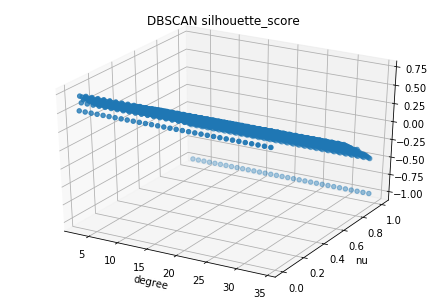

In [8]:
from mpl_toolkits.mplot3d import Axes3D

silhouette_score_list = []
nu_range = np.linspace(0.001,1,100)
degree_range = range(3,5*x.shape[1],1)

nu_list = list()
degree_list = list()

for nu_val in nu_range:
    for degree_val in degree_range:
    
        svm_clf = OneClassSVM(gamma='auto',nu = nu_val,degree=degree_val).fit(standard_x)
        y_pred =svm_clf.predict(standard_x)

        if len(np.unique(y_pred)) > 1:
            dbscan_silhouette_score = silhouette_score(x,y_pred)
            silhouette_score_list.append(dbscan_silhouette_score)
        else:
            silhouette_score_list.append(-1)
        nu_list.append(nu_val)
        degree_list.append(degree_val)
    

#3D plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(degree_list,nu_list, silhouette_score_list)#,c=y_pred
plt.xlabel('degree')
plt.ylabel('nu')
plt.title('DBSCAN silhouette_score')
plt.show()


## SVM - make cluster

In [56]:
silhouette_score_list[silhouette_score_np.argmax()]
nu_list[silhouette_score_np.argmax()]
#degree_list[silhouette_score_np.argmax()]
np.unique(y_pred)

array([-1,  1], dtype=int64)

In [57]:
x[y_pred==-1]

,Cabin Num,IsAlone,FamilySize,Parch,SibSp,Age,Fare
0,0,0,2,0,1,22.00,7.2500
1,0,0,2,0,1,38.00,71.2833
6,0,1,1,0,0,54.00,51.8625
7,0,0,5,1,3,2.00,21.0750
9,0,0,2,0,1,14.00,30.0708
10,0,0,3,1,1,4.00,16.7000
13,0,0,7,5,1,39.00,31.2750
15,0,1,1,0,0,55.00,16.0000
24,0,0,5,1,3,8.00,21.0750
27,0,0,6,2,3,19.00,263.0000
